## Import libraries and load dataset 

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

### Load given dataset

In [2]:
movies = pd.read_csv(r'movies.csv')
ratings = pd.read_csv(r'ratings.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


### Check data shape, columns and data types

In [4]:
movies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6 MB


The Movies dataset has:
- 3 features (2 categorical, 1 numerical)
- 10329 observations
- Dataset fits in 1.6 MB

In [5]:
ratings.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


The Ratings dataset has:
- 4 features (4 numerical)
- 105339 observations
- Dataset fits in 3.2 MB

### Check for missing values

In [6]:
movies.isnull().mean().sort_values(ascending=False)

movieId    0.0
title      0.0
genres     0.0
dtype: float64

In [7]:
ratings.isnull().mean().sort_values(ascending=False)

userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64

- No missing values in both datasets

### Splitting movie  title into year and title

In [8]:
movies['year'] = movies['title'].str[-5:-1]
movies['title'] = movies['title'].str[:-7]

movies = movies[['movieId','title','year','genres']]
movies.head()

,movieId,title,year,genres
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy


### Creating combined dataset of Movies and Ratings

In [9]:
# Merge Movies and Ratings
MovieRatings = pd.merge(ratings,movies, on='movieId').drop(columns='timestamp')


# Changing order of columns to make it easy to read
MovieRatings = MovieRatings[['movieId','title','year','userId','rating','genres']]

MovieRatings

,movieId,title,year,userId,rating,genres
0,16,Casino,1995,1,4.0,Crime|Drama
1,16,Casino,1995,9,4.0,Crime|Drama
2,16,Casino,1995,12,1.5,Crime|Drama
3,16,Casino,1995,24,4.0,Crime|Drama
4,16,Casino,1995,29,3.0,Crime|Drama
...,...,...,...,...,...,...
105334,140098,Runoff,2015,668,2.5,Drama
105335,140816,Tangerine,2015,668,2.5,Comedy|Drama
105336,141472,The 50 Year Argument,2014,668,2.5,(no genres listed)
105337,142488,Spotlight,2015,668,4.0,Thriller


### Data wrangling to transform pipe separated Genres into individual rows

In [10]:
# Split pipe separated Genres into individual columns
genre_columns = MovieRatings['genres'].str.split('|', expand=True )

# Concatenate with movies_ratings df 
MovieRatings_Genre_1 = pd.concat([MovieRatings,genre_columns], axis=1 ).drop(columns='genres')

# Unpivot the data
MovieRatings_Genre = MovieRatings_Genre_1.melt(id_vars=['movieId','title','year','userId','rating'], value_vars=[0, 1, 2,3,4,5,6,7,8,9], value_name='Genre').dropna().drop(columns='variable')

MovieRatings_Genre[(MovieRatings_Genre['movieId']==1)]

,movieId,title,year,userId,rating,Genre
14209,1,Toy Story,1995,2,5.0,Adventure
14210,1,Toy Story,1995,5,4.0,Adventure
14211,1,Toy Story,1995,8,5.0,Adventure
14212,1,Toy Story,1995,11,4.0,Adventure
14213,1,Toy Story,1995,14,4.0,Adventure
...,...,...,...,...,...,...
435792,1,Toy Story,1995,655,4.0,Fantasy
435793,1,Toy Story,1995,661,4.0,Fantasy
435794,1,Toy Story,1995,662,5.0,Fantasy
435795,1,Toy Story,1995,663,3.0,Fantasy


### Average rating and Total movies at Genre-movie level

In [11]:
# Create a dataframe that gives Genre & movie wise number of ratings and average rating for each movie

# Num Reviews
Genre_Movie_summary = pd.DataFrame(MovieRatings_Genre.groupby(['Genre','title'])['userId'].nunique()).rename(columns={'userId':'Num Reviews'})

# Average Movie Rating
Genre_Movie_summary['Average Movie Rating'] = MovieRatings_Genre.groupby(['Genre','title'])['rating'].mean()

Genre_Movie_summary = Genre_Movie_summary.reset_index().rename(columns={'title':'Movie Title'})

## Exploratory Data Analysis

### Task 1: Understanding of distribution of the features available 

In [12]:
# High level statistics for numerical variables

ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


- ['userid'] & ['movieId] These are ordinal identifiers. there are 668 users who have rated 149532 movies.
- ['rating'] has a normal distribution as mean is almost same as the median. Scale falls within 1 order of magnitude (from 0.5 to 5).
- ['timestamp'] This column can be dropped as it is not significant for analysis.

In [13]:
movies.describe(include='O')

,title,year,genres
count,10329,10329,10329
unique,10011,101,938
top,"Misérables, Les",2009,Drama
freq,4,374,1385


- Majority of the movies were release in 2009
- Popular movie genre is Drama

### Understanding Outliers using Boxplots

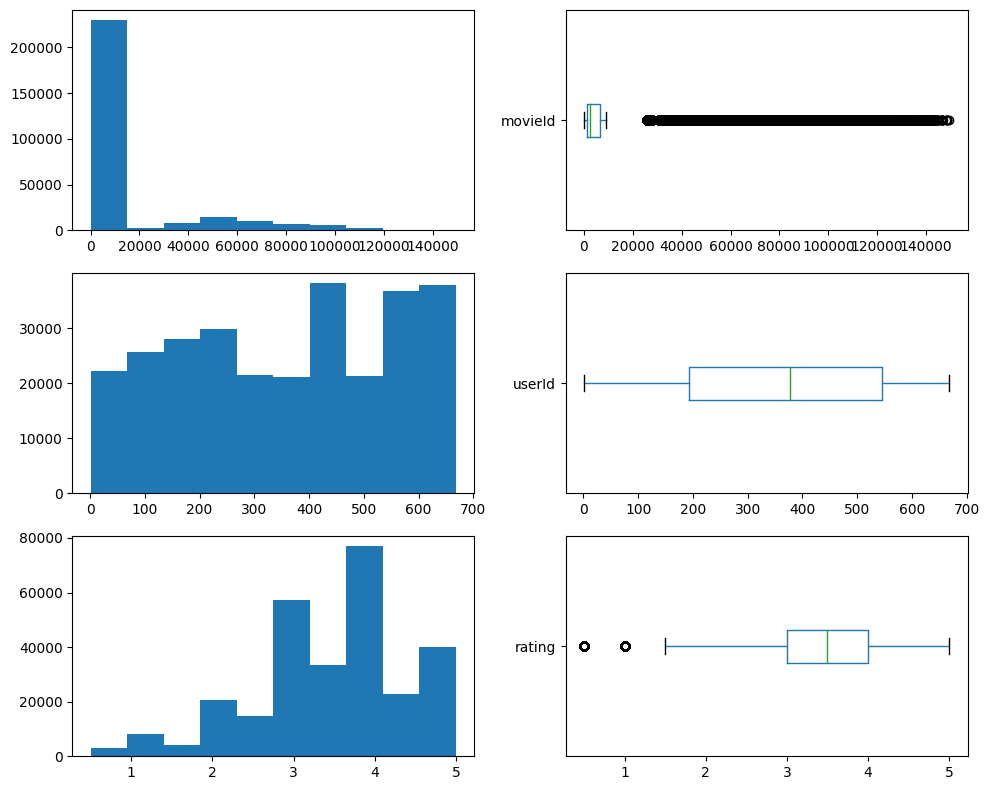

In [14]:
# Numerical columns with variance and distribution
numerical_features = list(MovieRatings_Genre.select_dtypes(include=['float64', 'int64']).columns)

# Generate histograms and boxplots

fig, axes = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(10,8))
for i, col in enumerate(numerical_features):
    MovieRatings_Genre[col].hist(ax=axes[i, 0], grid=False)
    MovieRatings_Genre.boxplot(column=col, ax=axes[i, 1], grid=False, vert=False)

plt.tight_layout()
plt.show()

- ['movieId'] and [userid] are ordinal identifiers and can be ignored from our analysis
- ['rating'] has 2 outliers that need outlier treatment

### Task 2: Average rating and Total movies at genre level

In [15]:
# Create a dataframe that gives Genre wise number of movies, number of ratings and average rating 

Genre_summary = pd.DataFrame(MovieRatings_Genre.groupby('Genre')['movieId'].nunique()).rename(columns={'movieId':'NoOfMovies'})
Genre_summary['NoOfRatings'] = MovieRatings_Genre.groupby('Genre')['userId'].nunique()
Genre_summary['AvgRating'] = MovieRatings_Genre.groupby('Genre')['rating'].mean()
Genre_summary = Genre_summary.reset_index().sort_values('NoOfRatings', ascending=False)
Genre_summary.head(10)

,Genre,NoOfMovies,NoOfRatings,AvgRating
8,Drama,5218,668,3.650266
2,Adventure,1164,667,3.518027
5,Comedy,3513,667,3.420996
17,Thriller,2187,666,3.495561
1,Action,1737,666,3.451450
15,Romance,1788,663,3.544255
6,Crime,1440,663,3.642392
16,Sci-Fi,859,659,3.454481
9,Fantasy,670,645,3.500459
14,Mystery,675,621,3.652043


### Top-rated movie genres with number of movies

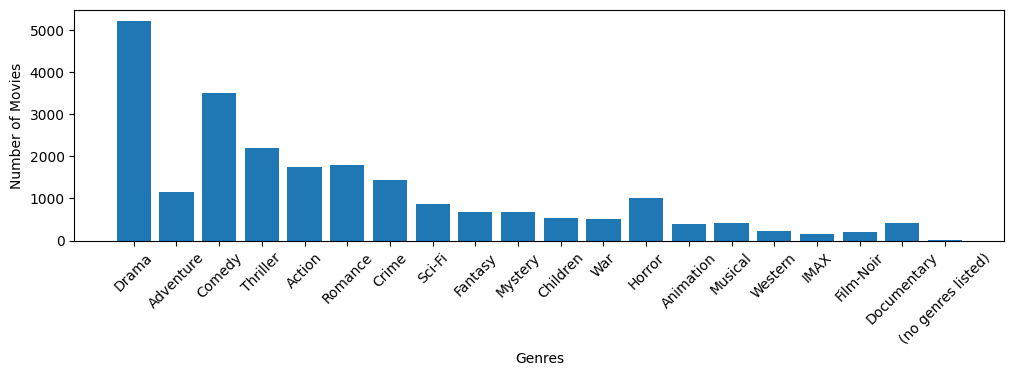

In [16]:
plt.figure(figsize=(12,3))
plt.bar(list(Genre_summary['Genre']), Genre_summary['NoOfMovies'])
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.show()

- We infer that Drama is the most popular genre with maximum number of movies and ratings
- While Adventure is second highest rated Genre, there are more Comedy movies than Adventure movies
- There is scope to make more adventure movies as they are being highly rated

### Distribution of Number of reviews vs. Movie rating

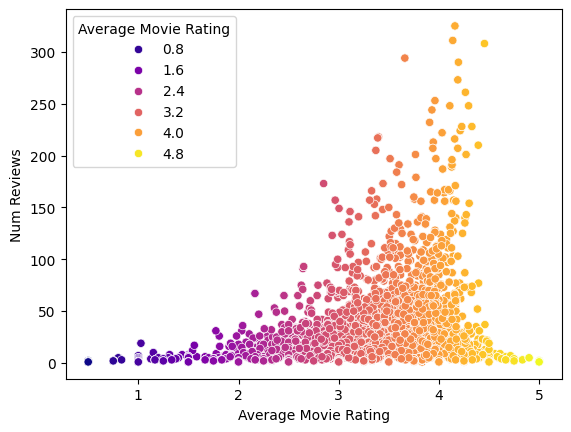

In [17]:
sns.scatterplot(data=Genre_Movie_summary,y="Num Reviews", x="Average Movie Rating",  hue="Average Movie Rating", palette='plasma')
plt.show()


- Seeing the distribution, we can infer that movies that have got higher number of user reviews have also got high rating.

### Task 3: Finding unique users and movies 

In [18]:
print('Number of unique users are: ', MovieRatings_Genre['userId'].nunique())
print('Number of unique movies are: ', MovieRatings_Genre['movieId'].nunique())

Number of unique users are:  668
Number of unique movies are:  10325


### Task 4: Unique genres considered

In [19]:
print('List of unique genres are:')
MovieRatings_Genre['Genre'].unique().tolist()

List of unique genres are:


['Crime',
 'Drama',
 'Mystery',
 'Action',
 'Adventure',
 'Comedy',
 'Thriller',
 'Horror',
 'Documentary',
 'Children',
 'Animation',
 'Film-Noir',
 'Fantasy',
 'Sci-Fi',
 'Musical',
 'Western',
 'Romance',
 'War',
 '(no genres listed)',
 'IMAX']

## Design the 3 different types of recommendation modules

### 1. Popularity-based recommender system

In [20]:
def popularity_based_recommendation(genre, minreviews, numrecomm):
    g = genre
    t = minreviews
    N = numrecomm

    # Create a subset of movies for Genre and minimum reviews entered by user
    Movieset_Popularity_1 = Genre_Movie_summary[(Genre_Movie_summary['Genre']==g) & (Genre_Movie_summary['Num Reviews']>=t)]

    # Add S.No to above subset by sorting on avg. movie rating in descending order    
    Movieset_Popularity_1['S.No'] = Movieset_Popularity_1.sort_values('Average Movie Rating', ascending=False)\
                        .groupby('Genre')\
                        .cumcount()+1

    # Rearrange column order for ease of understanding
    Movieset_Popularity_1.drop(columns='Genre')
    Movieset_Popularity_1 = Movieset_Popularity_1[['S.No','Movie Title','Average Movie Rating','Num Reviews']]\
                            .rename(columns={'Average Movie Rating':'Avg. Rating'})
    # Output dataframe that filters for number of recommendations that the user wants
    Movieset_Popularity = Movieset_Popularity_1[Movieset_Popularity_1['S.No']<=N].sort_values('S.No')
    
    return tabulate(Movieset_Popularity, headers='keys', showindex = 'never', tablefmt = 'simple_outline')

## 2. Content-based recommender system

### Step 1: Tf-idf Vectorizer

In [21]:
# Cleaning up values of Genre before applying TfidfVectorizer

movies['genres'] = movies['genres'].str.replace('(no genres listed)','No_Genres_Listed')
movies['genres'] = movies['genres'].str.replace('Sci-Fi','Sci_Fi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Film_Noir')

In [22]:
# Using TfidfVectorizer to find most significant genres for each movie

from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(stop_words='english')

tf_matrix = tf.fit_transform(movies['genres'])

In [23]:
# Shape of tfidf matrix output

tf_matrix.shape

(10329, 20)

In [24]:
# Column names of tfidf matrix output

tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'imax',
       'musical', 'mystery', 'no_genres_listed', 'romance', 'sci_fi',
       'thriller', 'war', 'western'], dtype=object)

In [25]:
# Viewing tfidf matrix output for 1st movie

tf_matrix[0].toarray()

array([[0.        , 0.40410292, 0.53921623, 0.50150636, 0.2638368 ,
        0.        , 0.        , 0.        , 0.47416052, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

### Step 2: Cosine similarity

In [26]:
# Calculating similarity between movies using cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

movie_similarity = cosine_similarity(tf_matrix) 

# Changing similarity of movie with itself from 1 to 0
np.fill_diagonal(movie_similarity, 0)     

# Creating a dataframe
movie_similarity_df = pd.DataFrame(movie_similarity)
movie_similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,...,10319,10320,10321,10322,10323,10324,10325,10326,10327,10328
0,0.000000,0.799772,0.158922,0.142838,0.263837,0.0,0.158922,0.644056,0.0,0.260439,...,0.000000,0.00000,0.0,0.205047,0.00000,0.782223,0.263837,0.263837,0.00000,0.0
1,0.799772,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.805299,0.0,0.325642,...,0.000000,0.00000,0.0,0.000000,0.00000,0.402028,0.000000,0.000000,0.00000,0.0
2,0.158922,0.000000,0.000000,0.898795,0.602350,0.0,1.000000,0.000000,0.0,0.000000,...,0.000000,0.00000,0.0,0.468130,0.00000,0.203167,0.602350,0.602350,0.00000,0.0
3,0.142838,0.000000,0.898795,0.000000,0.541389,0.0,0.898795,0.000000,0.0,0.000000,...,0.144405,0.43837,0.0,0.696614,0.43837,0.182606,0.541389,0.541389,0.43837,0.0
4,0.263837,0.000000,0.602350,0.541389,0.000000,0.0,0.602350,0.000000,0.0,0.000000,...,0.000000,0.00000,0.0,0.777173,0.00000,0.337291,1.000000,1.000000,0.00000,0.0


In [27]:
movie_similarity.shape

(10329, 10329)

In [28]:
def content_based_recommendation(movie, numrecomm):
    t = movie
    N = int(numrecomm)

    global movies
    
    # Fetch index of user input movie from movies dataframe
    index_t = movies[movies['title']==t].index.tolist()  
    index_t = index_t[0] 

    # Adding similarity from movie_similarity using index
    movies['similarity'] = movie_similarity_df.iloc[index_t]

    Movieset_Content_1 = movies.copy().sort_values('similarity', ascending=False)
    movies= movies.drop(columns='similarity')

    Movieset_Content_1['Sl.No'] = range(1, len(Movieset_Content_1)+1)
    Movieset_Content_1 = Movieset_Content_1[['Sl.No','title']].rename(columns={'title':'Movie Title'})

    # Output dataframe that filters for number of recommendations that the user wants
    Movieset_Content = Movieset_Content_1[Movieset_Content_1['Sl.No']<=N]

    # Removing the default integer index while printing the dataframe
    return tabulate(Movieset_Content, headers='keys', showindex = 'never', tablefmt = 'simple_outline')

### 3. Collaborative-based recommender system

In [29]:
def collaborative_based_recommendation(userid, numrecomm, simusers):
    u = userid
    N = numrecomm
    k = simusers


    # Create the dataframe containing list of movies rated by the target user

    Collab_df = MovieRatings[['userId','movieId','title','year','rating']]
    
    user_rated = Collab_df[Collab_df['userId']==u]
    # user_rated.head()


    # Find peers who have watched the same movies as the target user 
    peers = Collab_df[Collab_df['movieId'].isin(user_rated['movieId'])]

    # Excluding target user from peer list
    peers = peers[peers['userId'] != u]
    # print('There are ',peers['userId'].nunique(), ' users who have watched the same movies as the target user')
   
    # Grouping by userId to create sub dataframes for each user
    # This will help in quantifying the number of movies that are common between each peer and the target user
    # Assumption is: Higher the number of common movies rated, more similar are the users 

    peers_grp = peers.groupby('userId')
  

    # Create Pearson Coefficient of Correlation to find users similar to the target user based on ratings given
    
    pearson_coef={}

    for name, peer in peers_grp:

        # Fetch only those target user movies that the peer has watched
        user_peer_watched = user_rated[user_rated['movieId'].isin(peer['movieId'])]

        # Sort by movie id
        user_peer_watched = user_peer_watched.sort_values('movieId')
        peer = peer.sort_values('movieId')

        # Add ratings to a list
        user_rating_list = user_peer_watched['rating'].tolist()
        peer_rating_list = peer['rating'].tolist()

        # Calculate Pearson's coefficient
        if (len(user_rating_list)>1) & (len(user_rating_list)>1):
            pearson_coef[name] = stats.pearsonr(user_rating_list, peer_rating_list).statistic


    # Convert dict to dataframe
    pearson_coef_df = pd.DataFrame.from_dict(pearson_coef, orient='index').fillna(0).reset_index().rename(columns={'index':'userId', 0:'SimilarityCoef'})

    # Filter the above to get list of "K" similar users
    pearson_coef_df = pearson_coef_df.sort_values('SimilarityCoef', ascending = False)[:k]

    # Fetching movie and ratings info for list of similar peers
    similar_peers = Collab_df[Collab_df['userId'].isin(pearson_coef_df['userId'])]

    # Exclude movies that are already watched by the target user
    similar_peers = similar_peers[~similar_peers['movieId'].isin(user_rated['movieId'])]

    # Adding Similarity Coefficient
    similar_peers = similar_peers.merge(pearson_coef_df, on='userId')


    # The similar users may have rated common movies. In order to determine which are the top movies to recommend,
    # we take weighted average of ratings using SimilarityCoef as the weight

    similar_peers['wt_rating'] = similar_peers['rating']*similar_peers['SimilarityCoef']


    # For each movie, calculate the weighted average rating across all similar users
    peer_recommended_movies = pd.DataFrame(similar_peers.groupby(['title','year'])[['wt_rating','SimilarityCoef']].sum()).reset_index().rename(columns={'wt_rating':'WeightedSum','SimilarityCoef':'SumOfWeights'})
    peer_recommended_movies['WeightedAvgScore'] = peer_recommended_movies['WeightedSum']/ peer_recommended_movies['SumOfWeights']

    # Sorting in descending order of weighted average rating
    peer_recommended_movies = peer_recommended_movies.sort_values('WeightedAvgScore', ascending=False)
    peer_recommended_movies['S.No'] = range(1,len(peer_recommended_movies)+1)

    # Filter for top N peer recommended movies 
    Movieset_Collaborative = peer_recommended_movies[peer_recommended_movies['S.No']<=N]
    Movieset_Collaborative = Movieset_Collaborative[['S.No','title']].rename(columns={'title':'Movie Title'})

    return tabulate(Movieset_Collaborative, headers='keys', showindex = 'never', tablefmt = 'simple_outline')

## Creating a GUI interface using Python library Tkinter 

### Import required libraries

In [30]:
import tkinter as tk
from tkinter import ttk

### Define functions that pass input from GUI to each recommendation module

In [31]:
def popularity():

    g = genre_entry.get()  
    t = int(minreviews_entry.get())
    N = int(pop_numrecomm_entry.get())
    
    # Call the Popularity-based recommender
    o = popularity_based_recommendation(g, t, N)
    
    # Print the output    
    output_text.insert(tk.END, f"\n\nPopularity-Based Recommendation for genre: {g} \n\n")
    output_text.insert(tk.END, o)

def content():
    t = movie_combobox.get()  # Get the movie name from the entry widget
    N = int(cont_numrecomm_entry.get())

    # Call the Content-based recommender
    o = content_based_recommendation(t, N)
    
    # Print the output    
    output_text.insert(tk.END, f"\n\nRecommended movies based on your choice of {t}: \n\n") 
    output_text.insert(tk.END, o)


def collaborative():

    u = int(user_entry.get())  
    N = int(coll_numrecomm_entry.get())
    k = int(simusers_entry.get())
    
    # Call the Collaborative-based recommender
    o = collaborative_based_recommendation(u, N, k)
    
    # Print the output  
    output_text.insert(tk.END, f"\n\nCollaborative-Based Recommendation for user: {u} \n\n")
    output_text.insert(tk.END, o)

### Creating the GUI

In [34]:
def main():
    root = tk.Tk()
    root.title("Movie Recommendation System")
    
    
    # Define custom style
    
    # Filter dropdown style
    style = ttk.Style()
    style.theme_create("custom_style", parent="alt", settings={
        "TCombobox": {
            "configure": {"selectbackground": "grey", "selectforeground": "black", "width": 50},
        },
        "TButton": {
            "background": "white",
            "borderwidth": 2
        }
    })
    style.theme_use("custom_style")
    
    # Button style
    style.configure('TButton', background = 'blue', foreground = 'white', width = 12, borderwidth=1, focusthickness=3, focuscolor='none')
    style.map('TButton', background=[('active','white')], foreground=[('active','black')])
    



    # Create a Notebook (tabbed interface)
    notebook = ttk.Notebook(root)
    notebook.pack(fill=tk.BOTH, expand=True)
    
    
    # --------------------------------------------- POPULARITY-BASED ----------------------------------------- #
    
    popularity_based_tab = ttk.Frame(notebook)
    notebook.add(popularity_based_tab, text='Popularity-Based')

    
    # Inputs for popularity-based recommendation
    
    # Title
    ttk.Label(popularity_based_tab).pack()
    popularity_label = ttk.Label(popularity_based_tab, text="Popularity-Based Recommendation", font=("TkDefaultFont", 12, "bold"))
    popularity_label.pack()  
    ttk.Label(popularity_based_tab).pack()
    
    # Genre
    genre_entry_label = ttk.Label(popularity_based_tab, text="Enter Genre:")
    genre_entry_label.pack()
    
    global genre_entry
    genre_entry = ttk.Combobox(popularity_based_tab, values=MovieRatings_Genre['Genre'].unique().tolist(), state="readonly")
    genre_entry.pack()
       
    # Minimum reviews threshold
    minreviews_entry_label = ttk.Label(popularity_based_tab, text="Enter minimum reviews:")
    minreviews_entry_label.pack()

    global minreviews_entry
    minreviews_entry = ttk.Entry(popularity_based_tab)
    minreviews_entry.pack()

    # Number of recommendations
    pop_numrecomm_entry_label = ttk.Label(popularity_based_tab, text="Enter number of recommendations you would like to see:")
    pop_numrecomm_entry_label.pack()

    global pop_numrecomm_entry
    pop_numrecomm_entry = ttk.Entry(popularity_based_tab)
    pop_numrecomm_entry.pack()
    
    # Recommend button       
    ttk.Label(popularity_based_tab).pack()
    popularity_button = ttk.Button(popularity_based_tab, text="Recommend", command=popularity)
    popularity_button.pack()
    ttk.Label(popularity_based_tab).pack() # Add padding
    
    

    # --------------------------------------------- CONTENT-BASED ----------------------------------------- #
    
    content_based_tab = ttk.Frame(notebook)
    notebook.add(content_based_tab, text='Content-Based')

    # Inputs for content-based recommendation
    
    # Title
    ttk.Label(content_based_tab).pack()
    content_label = ttk.Label(content_based_tab, text="Content-Based Recommendation", font=("TkDefaultFont", 12, "bold"))
    content_label.pack()
    ttk.Label(content_based_tab).pack()
    
    # Movie name
    movie_entry_label = ttk.Label(content_based_tab, text="Select the reference Movie Title based on which recommendations are to be made:")
    movie_entry_label.pack()

    global movie_combobox
    movie_combobox = ttk.Combobox(content_based_tab, values=movies['title'].tolist(), state="readonly", width=50)
    movie_combobox.pack()
    
    cont_numrecomm_entry_label = ttk.Label(content_based_tab, text="Enter number of recommendations you would like to see:")
    cont_numrecomm_entry_label.pack()
    
    # Number of recommendations
    global cont_numrecomm_entry
    cont_numrecomm_entry = ttk.Entry(content_based_tab)
    cont_numrecomm_entry.pack()
    
    # Recommend button     
    ttk.Label(content_based_tab).pack()
    content_button = ttk.Button(content_based_tab, text="Recommend", command=content)
    content_button.pack()
    ttk.Label(content_based_tab).pack()

    
    
    # --------------------------------------------- COLLABORATIVE-BASED ----------------------------------------- #
    
    collaborative_filtering_tab = ttk.Frame(notebook)
    notebook.add(collaborative_filtering_tab, text='Collaborative Filtering')

    # Inputs for collaborative filtering recommendation
        
    # Title
    ttk.Label(collaborative_filtering_tab).pack()
    collaborative_label = ttk.Label(collaborative_filtering_tab, text="Collaborative Filtering Recommendation", font=("TkDefaultFont", 12, "bold"))
    collaborative_label.pack()
    ttk.Label(collaborative_filtering_tab).pack()

    # Target user
    user_entry_label = ttk.Label(collaborative_filtering_tab, text="Enter target User ID (between 1 and 668):")
    user_entry_label.pack()

    global user_entry
    user_entry = ttk.Entry(collaborative_filtering_tab)
    user_entry.pack()
    
    # Number of recommendations
    coll_numrecomm_entry_label = ttk.Label(collaborative_filtering_tab, text="Enter number of recommendations you would like to see:")
    coll_numrecomm_entry_label.pack()

    global coll_numrecomm_entry
    coll_numrecomm_entry = ttk.Entry(collaborative_filtering_tab)
    coll_numrecomm_entry.pack()
    
    # Similar users threshold
    simusers_entry_label = ttk.Label(collaborative_filtering_tab, text="Enter the threshold for similar users based on whom recommendations are to be made:")
    simusers_entry_label.pack()

    global simusers_entry
    simusers_entry = ttk.Entry(collaborative_filtering_tab)
    simusers_entry.pack()    

    # Recommend button 
    ttk.Label(collaborative_filtering_tab).pack()
    collaborative_button = ttk.Button(collaborative_filtering_tab, text="Recommend", command=collaborative)
    collaborative_button.pack()
    ttk.Label(collaborative_filtering_tab).pack()

    
    # Create output console
    global output_text
    output_text = tk.Text(root, height=40, width=150)
    output_text.pack()
    
    # Run the application
    root.mainloop()

### Open Movie Recommender

In [35]:
if __name__ == "__main__":
    main()

## End of Assignment